# Main Figures
## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Load Dependencies
import numpy as np
import seaborn as sns
import StudyI_Pentatonic_vs_Chromatic.paths as StudyI_paths
import StudyII_All_5_note_Sets.paths as StudyII_paths
import Study_Likert.paths as Study_likert_paths
import Study_Uniform.paths as Study_uniform_paths
import Study_Tritave_Uniform.paths as Study_tritave_paths
import Study_Tritave_pentachords.paths as Study_tritave_pentachords_paths
import pandas as pd
import matplotlib.pyplot as plt
import os
from Shared_Scripts.plotting_functions import correlation, distribution, ridge_coeffs
from scipy.stats import zscore
from scipy import stats
import pingouin as pg
from Shared_Scripts.stat_funcs import cohen_d_one_sample, cohen_d_independent_t_test

In [2]:
# Mark as true to run statistics
Run_Stats = True
# Set number of permutation tests (for interval analysis)
reps = 10000

In [3]:
# Load Data
studyI_GL = pd.read_pickle(
    StudyI_paths.processed_dir + StudyI_paths.post_exclusion_data_pickle_filename)  # Study I: Post-exclusion group-level data

# Load Data
studyII_GL = pd.read_pickle(
    StudyII_paths.processed_dir + StudyII_paths.post_exclusion_data_pickle_filename)  # Study II: Post-exclusion group-level data

study_likert = pd.read_pickle(
    Study_likert_paths.processed_dir + Study_likert_paths.post_exclusion_data_pickle_filename)  # Study II: Post-exclusion group-level #data

study_uniform = pd.read_pickle(
    Study_uniform_paths.processed_dir + Study_uniform_paths.post_exclusion_data_pickle_filename)  # Study Uniform Sets: Post-exclusion group-level #data

study_tritave_uniform = pd.read_pickle(
    Study_tritave_paths.processed_dir + Study_tritave_paths.post_exclusion_data_pickle_filename)  # Study Tritave Uniform Sets: Post-exclusion group-level #data

study_tritave_pentachord = pd.read_pickle(
    Study_tritave_pentachords_paths.processed_dir + Study_tritave_pentachords_paths.post_exclusion_data_pickle_filename)  # Study Tritave Pentachord Sets: Post-exclusion group-level #data

ROOT_DIR = os.path.abspath(os.getcwd())  # This is where this file is

In [4]:
# Adding extra features:
studyII_GL['EOS_std'] = studyII_GL['evenness_of_spread']**(1/2)
studyII_GL['EOS_log'] = np.log2(studyII_GL['evenness_of_spread'])
studyII_GL['cvr'] = np.log2(studyII_GL['cardinality_variety_ratio'])
studyII_GL['tonal_ambiguity'] = 12/pow(2,studyII_GL['tonal_entropy'])

## Figure 1 - Study I - Rate of shifted and swapped across all melody lengths (ignoring neithers)

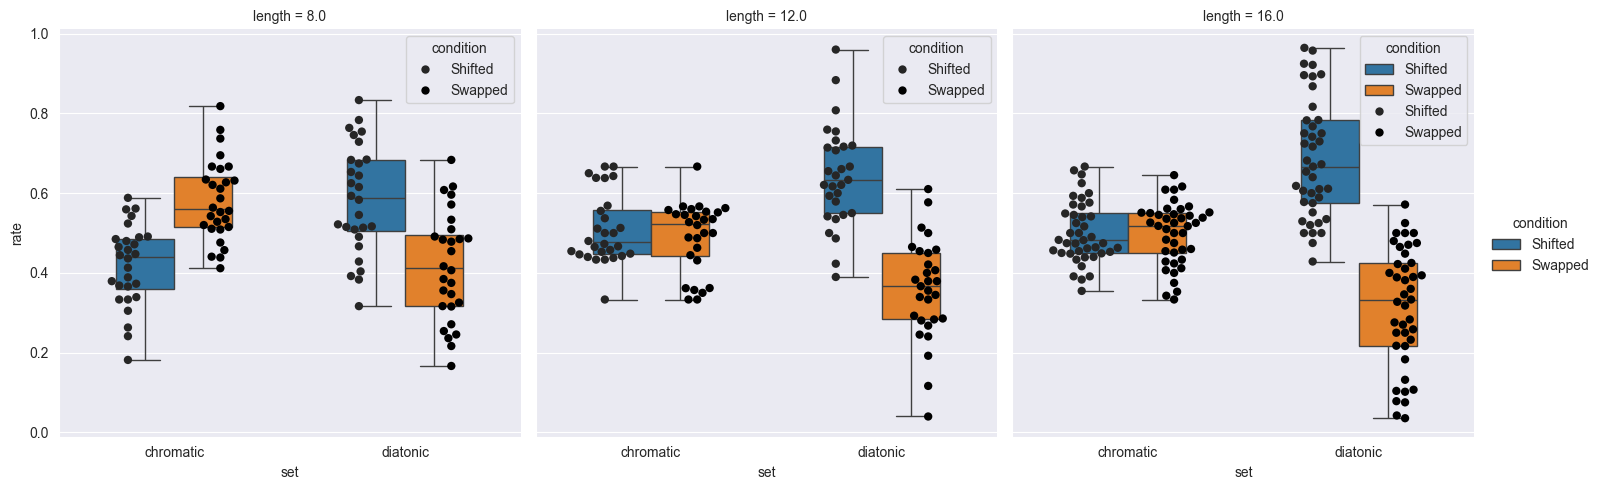

In [5]:
# Study I: Rate of shifted and swapped across all lengths (ignoring neithers)
temp = studyI_GL
temp = temp[['rate_NN_shifted','rate_NN_swapped','length','set']]
temp2 = pd.melt(temp,id_vars=["length","set"],var_name="condition",value_name="rate")
temp2['condition'] = temp2['condition'].replace('rate_NN_shifted',"Shifted")
temp2['condition'] = temp2['condition'].replace('rate_NN_swapped',"Swapped")

ax = sns.catplot(x="set", y="rate", data=temp2, col="length", kind="box", hue="condition", fliersize=0.5, width=0.5, height=5, aspect=1)
# ax = sns.catplot(x="set", y="rate", data=temp2, col="length", kind="swarm", hue="condition", dodge=True, height=5, aspect=1.57, ax=ax)
only_data_with_length_8 = temp2[temp2['length']==8]
sns.swarmplot(data=only_data_with_length_8, x="set", y="rate", hue="condition", palette='dark:black', dodge=True, ax=ax.axes[0][0], size=6)

only_data_with_length_12= temp2[temp2['length']==12]
sns.swarmplot(data=only_data_with_length_12, x="set", y="rate", hue="condition", palette='dark:black', dodge=True, ax=ax.axes[0][1], size=6)

only_data_with_length_16= temp2[temp2['length']==16]
sns.swarmplot(data=only_data_with_length_16, x="set", y="rate", hue="condition", palette='dark:black', dodge=True, ax=ax.axes[0][2], size=6)

# plt.ylim([0.2,0.8])
plt.savefig(StudyI_paths.plots_dir + "rate of shifted AND swapped (NN).svg")

## Plotting the same but y-axis represented bias toward note deviations (shifted - swapped)

<Axes: title={'center': 'length = 16.0'}, xlabel='set', ylabel='rate shifted - rate swapped (NN)'>

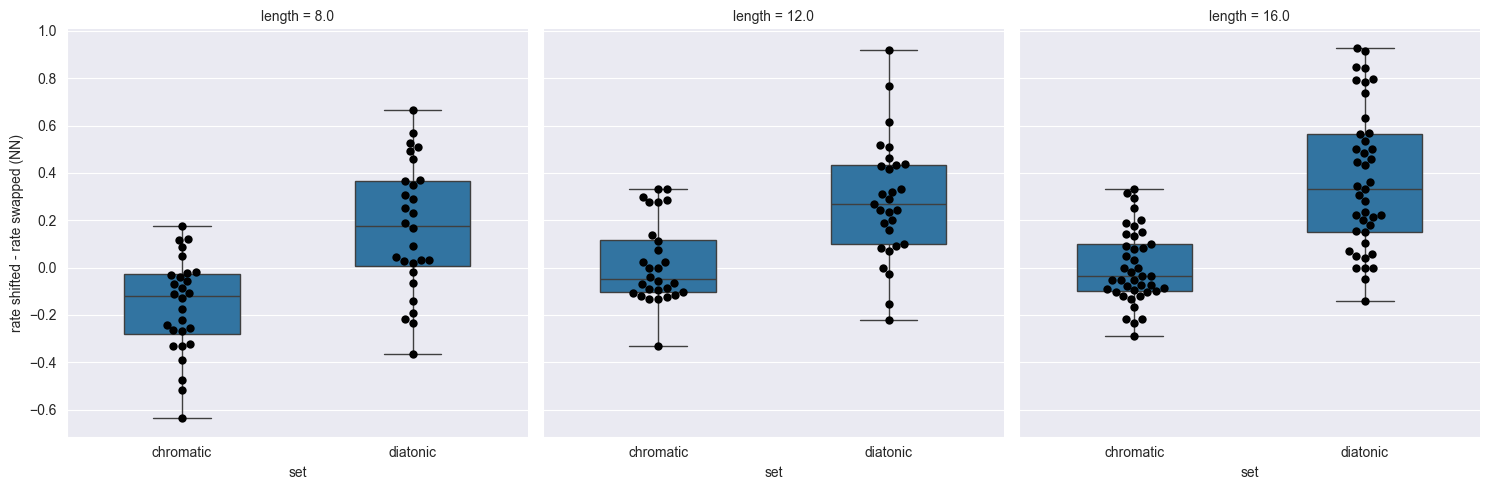

In [6]:
# Study I: Rate of shifted and swapped across all lengths (ignoring neithers)
temp = studyI_GL
ax = sns.catplot(x="set", y="rate shifted - rate swapped (NN)", data=temp, kind="box", col="length", fliersize=0.5, width=0.5, height=5, aspect=1)
# Plot swarmplot for each length
only_data_with_length_8 = temp[temp['length']==8]
sns.swarmplot(data=only_data_with_length_8, x="set", y="rate shifted - rate swapped (NN)", color='black', dodge=True, ax=ax.axes[0][0], size=6)

only_data_with_length_12 = temp[temp['length']==12]
sns.swarmplot(data=only_data_with_length_12, x="set", y="rate shifted - rate swapped (NN)", color='black', dodge=True, ax=ax.axes[0][1], size=6)

only_data_with_length_16 = temp[temp['length']==16]
sns.swarmplot(data=only_data_with_length_16, x="set", y="rate shifted - rate swapped (NN)", color='black', dodge=True, ax=ax.axes[0][2], size=6)

## Run Statistics for Expt.1 (one-sample t-test over differences)

In [7]:
st1 = studyI_GL
# get only melody lengths
only_data_with_length_8 = st1[st1['length']==8]
only_data_with_length_12 = st1[st1['length']==12]
only_data_with_length_16 = st1[st1['length']==16]

# get only diatonic set for each melody length
only_data_with_length_8_diatonic = only_data_with_length_8[only_data_with_length_8['set']=='diatonic']
only_data_with_length_12_diatonic = only_data_with_length_12[only_data_with_length_12['set']=='diatonic']
only_data_with_length_16_diatonic = only_data_with_length_16[only_data_with_length_16['set']=='diatonic']

# get only chromatic set for each melody length
only_data_with_length_8_chromatic = only_data_with_length_8[only_data_with_length_8['set']=='chromatic']
only_data_with_length_12_chromatic = only_data_with_length_12[only_data_with_length_12['set']=='chromatic']
only_data_with_length_16_chromatic = only_data_with_length_16[only_data_with_length_16['set']=='chromatic']

In [9]:
if Run_Stats:
    # 8-notes (one-way t-test)
    #st1 = studyI_GL
    
    #note_8_chromatic = only_data_with_length_8[only_data_with_length_8['set']=='chromatic']
    #note_8_pentatonic = only_data_with_length_8[only_data_with_length_8['set']=='diatonic']
    
    # compute diatonic stats
    [T_Val_8_note_diatonic, P_8_note_diatonic] = stats.ttest_1samp(only_data_with_length_8_diatonic["rate shifted - rate swapped (NN)"].values, 0)
    [T_Val_12_note_diatonic, P_12_note_diatonic] = stats.ttest_1samp(only_data_with_length_12_diatonic["rate shifted - rate swapped (NN)"].values, 0)
    [T_Val_16_note_diatonic, P_16_note_diatonic] = stats.ttest_1samp(only_data_with_length_16_diatonic["rate shifted - rate swapped (NN)"].values, 0)
    
    # compute chromatic stats
    [T_Val_8_note_chromatic, P_8_note_chromatic] = stats.ttest_1samp(only_data_with_length_8_chromatic["rate shifted - rate swapped (NN)"].values, 0)
    [T_Val_12_note_chromatic, P_12_note_chromatic] = stats.ttest_1samp(only_data_with_length_12_chromatic["rate shifted - rate swapped (NN)"].values, 0)
    [T_Val_16_note_chromatic, P_16_note_chromatic] = stats.ttest_1samp(only_data_with_length_16_chromatic["rate shifted - rate swapped (NN)"].values, 0)
    
    
    # compute effect sizes
    effect_size_8_note_diatonic = cohen_d_one_sample(only_data_with_length_8_diatonic["rate shifted - rate swapped (NN)"].values, 0)
    effect_size_12_note_diatonic = cohen_d_one_sample(only_data_with_length_12_diatonic["rate shifted - rate swapped (NN)"].values, 0)
    effect_size_16_note_diatonic = cohen_d_one_sample(only_data_with_length_16_diatonic["rate shifted - rate swapped (NN)"].values, 0)
    
    # compute effect sizes
    effect_size_8_note_chromatic = cohen_d_one_sample(only_data_with_length_8_chromatic["rate shifted - rate swapped (NN)"].values, 0)
    effect_size_12_note_chromatic = cohen_d_one_sample(only_data_with_length_12_chromatic["rate shifted - rate swapped (NN)"].values, 0)
    effect_size_16_note_chromatic = cohen_d_one_sample(only_data_with_length_16_chromatic["rate shifted - rate swapped (NN)"].values, 0)
    
    #print with titles
    print("8-note diatonic: ", P_8_note_diatonic, T_Val_8_note_diatonic)
    print("12-note diatonic: ", P_12_note_diatonic, T_Val_12_note_diatonic)
    print("16-note diatonic: ", P_16_note_diatonic, T_Val_16_note_diatonic)
    print("8-note chromatic: ", P_8_note_chromatic, T_Val_8_note_chromatic)
    print("12-note chromatic: ", P_12_note_chromatic, T_Val_12_note_chromatic)
    print("16-note chromatic: ", P_16_note_chromatic,T_Val_16_note_chromatic)

#Stats with shifted rate only
if 0:
    #8-notes (one-way t-test)
    #note_8_chromatic = only_data_with_length_8[only_data_with_length_8['set']=='chromatic']
    #note_8_pentatonic = only_data_with_length_8[only_data_with_length_8['set']=='diatonic']

    #[T_Val_8_note_chromatic, P_8_note_chromatic] = stats.ttest_1samp(note_8_chromatic[note_8_chromatic['condition']=='Shifted']['rate'].values, 0.5)
    #[T_Val_8_note_pentatonic, P_8_note_pentatonic] = stats.ttest_1samp(note_8_pentatonic[note_8_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    
    #effect_size_8_note_pentatonic = cohen_d_one_sample(note_8_pentatonic[note_8_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    #effect_size_8_note_chromatic = cohen_d_one_sample(note_8_chromatic[note_8_chromatic['condition']=='Shifted']['rate'].values, 0.5)

    # 12-notes (one-way t-test)
    #note_12_chromatic = only_data_with_length_12[only_data_with_length_12['set']=='chromatic']
    #note_12_pentatonic = only_data_with_length_12[only_data_with_length_12['set']=='diatonic']

    #[T_Val_12_note_chromatic, P_12_note_chromatic] = stats.ttest_1samp(note_12_chromatic[note_12_chromatic['condition']=='Shifted']['rate'].values, 0.5)
    #[T_Val_12_note_pentatonic, P_12_note_pentatonic] = stats.ttest_1samp(note_12_pentatonic[note_12_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    
    #effect_size_12_note_pentatonic = cohen_d_one_sample(note_12_pentatonic[note_12_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    #effect_size_12_note_chromatic = cohen_d_one_sample(note_12_chromatic[note_12_chromatic['condition']=='Shifted']['rate'].values, 0.5)

    # 16-notes (one-way t-test)
    #note_16_chromatic = only_data_with_length_16[only_data_with_length_16['set']=='chromatic']
    #note_16_pentatonic = only_data_with_length_16[only_data_with_length_16['set']=='diatonic']

    #[T_Val_16_note_chromatic, P_16_note_chromatic] = stats.ttest_1samp(note_16_chromatic[note_16_chromatic['condition']=='Shifted']['rate'].values, 0.5)
    #[T_Val_16_note_pentatonic, P_16_note_pentatonic] = stats.ttest_1samp(note_16_pentatonic[note_16_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    
    #effect_size_16_note_pentatonic = cohen_d_one_sample(note_16_pentatonic[note_16_pentatonic['condition']=='Shifted']['rate'].values, 0.5)
    #effect_size_16_note_chromatic = cohen_d_one_sample(note_16_chromatic[note_16_chromatic['condition']=='Shifted']['rate'].values, 0.5)
    
    #Stats with shifted rate only

8-note diatonic:  0.002854377977390189 3.2810194635454484
12-note diatonic:  1.6425035980259898e-06 6.040217279106911
16-note diatonic:  1.0110096898627894e-09 7.92128248951394
8-note chromatic:  0.0002383295223974802 -4.232994353046165
12-note chromatic:  0.5910440668678547 0.5437963932835493
16-note chromatic:  0.940379292008748 0.07526468105324166


In [11]:
# Runs mixed anova (length x set) on rate of shifted and swapped
if Run_Stats:
    temp = studyI_GL
    temp = temp[['subject', 'rate_NN_shifted','rate_NN_swapped', 'rate shifted - rate swapped (NN)','length','set']]
    temp.loc[:,'rate shifted - rate swapped (NN)'] = temp.loc[:,'rate shifted - rate swapped (NN)'].astype('float')
    temp.loc[:,'length'] = temp.loc[:,'length'].astype('object')
    temp.reset_index(inplace=True)
    temp = temp.drop(['index'], axis=1)
    exp1_mixed_anova_results = pg.mixed_anova(dv='rate shifted - rate swapped (NN)', between='length',
                             within='set', subject='subject', data=temp)
    
    print(exp1_mixed_anova_results)

        Source        SS  DF1  DF2        MS           F         p-unc  \
0       length  1.166822    2   94  0.583411    8.726643  3.339212e-04   
1          set  5.238290    1   94  5.238290  125.069634  5.784227e-19   
2  Interaction  0.076977    2   94  0.038489    0.918958  4.024881e-01   

        np2  eps  
0  0.156597  NaN  
1  0.570913  1.0  
2  0.019177  NaN  


## Figure 2 - Study II - Rate of shifted-rate of swapped when ignoring neither trials

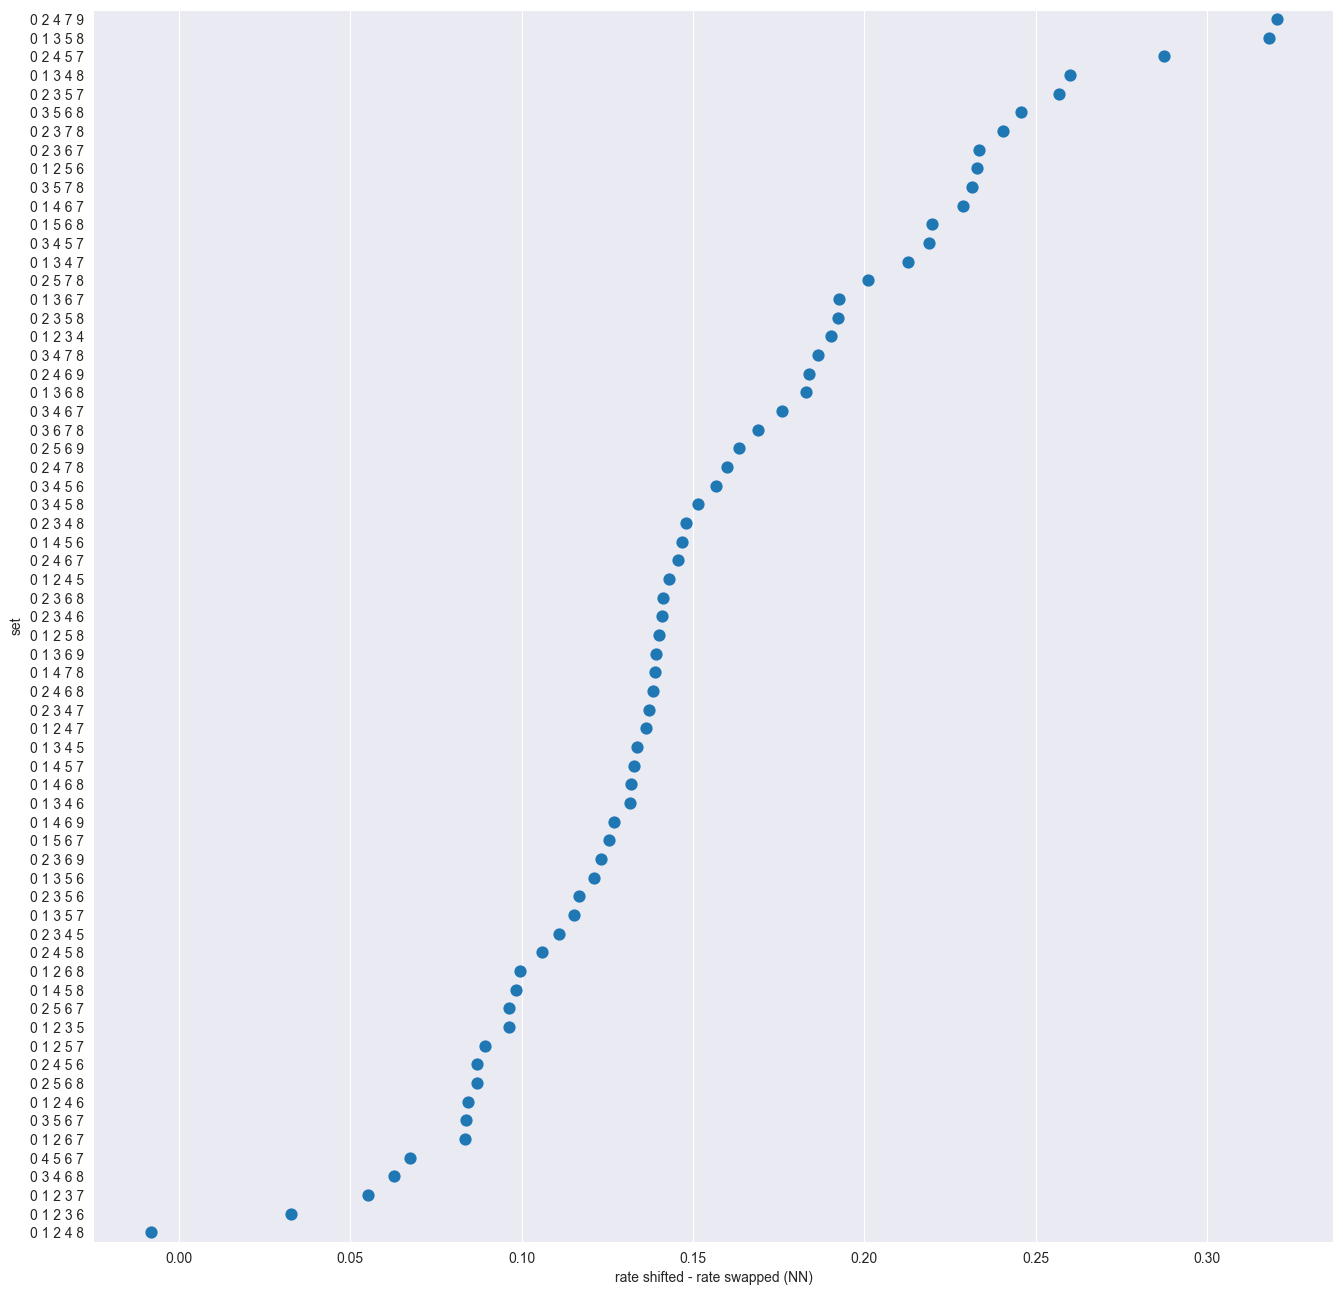

In [6]:
temp = studyII_GL
plot_order = temp.groupby('set').mean(numeric_only = True).sort_values(by=["rate shifted - rate swapped (NN)"], ascending=False).index.values
fig, ax = plt.subplots(figsize=(16, 16))
sns.pointplot(ax=ax, y="set", x="rate shifted - rate swapped (NN)", data=temp, order=plot_order,linestyle='none', errorbar=('ci', 0))
plt.savefig(ROOT_DIR + "/Plots/Study II 66 set distribution.svg")

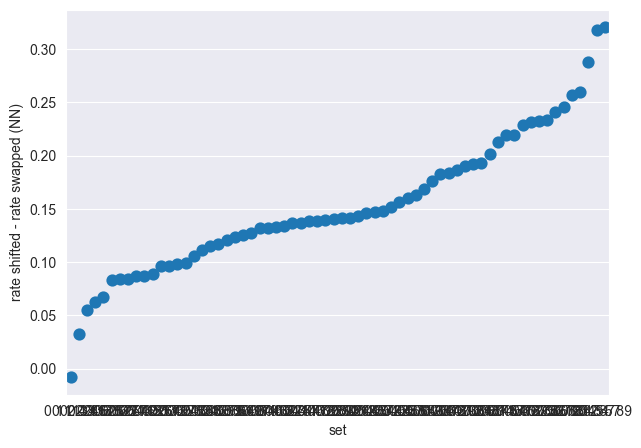

In [7]:
# plot with flipped x and y axes

temp =studyII_GL
plot_order = temp.groupby('set').mean(numeric_only = True).sort_values(by=["rate shifted - rate swapped (NN)"], ascending=True).index.values
# plot_order = [s for index, s in enumerate(plot_order) if index%5==0]
# print(plot_order)
# temp = temp[temp['set'].isin(plot_order)]
fig, ax = plt.subplots(figsize=(7, 5))
sns.pointplot(ax=ax, x="set", y="rate shifted - rate swapped (NN)", data=temp, order=plot_order,linestyle='none', errorbar=('ci', 0))
plt.savefig(ROOT_DIR + "/Plots/Study II 66 set distribution-flipped.svg")

## Figure 4 - Comparing Study I to Study II


/var/folders/bm/tx0fw97s0w5020l7n7hth5mc0000gn/T/ipykernel_4251/3099829719.py:21: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.swarmplot(data=new_df, x="group", y="rate shifted - rate swapped (NN)", hue="study", order=['worst','pentatonic'], color='black', dodge=True, size=5)


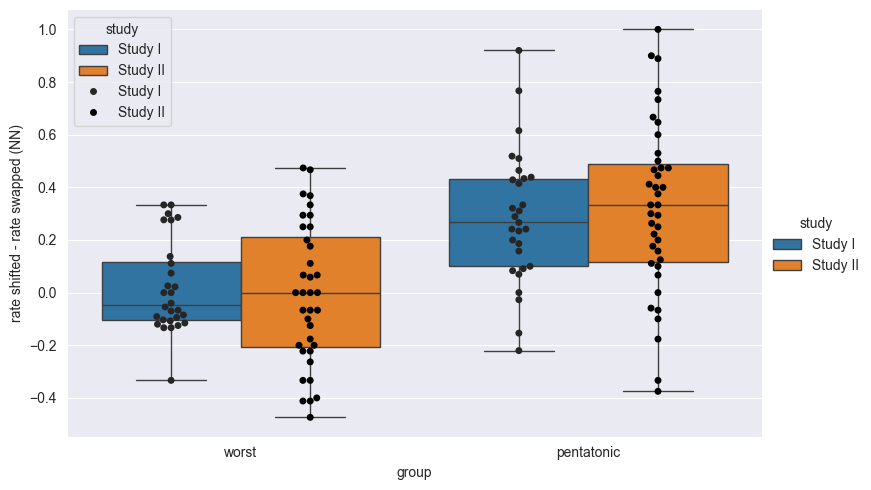

In [8]:
st1 = studyI_GL
st1 = st1[st1['length']==12].reset_index()
s1_best = st1[st1['set']=='diatonic'].reset_index(drop=True)
s1_best['group']='pentatonic'
s1_worst = st1[st1['set']!='diatonic'].reset_index(drop=True)
s1_worst['group']='worst'
st1 = pd.concat([s1_best,s1_worst]).reset_index(drop=True)
st1['study'] = "Study I"

st2 = studyII_GL
st2 = st2[st2['set'].isin(['0 2 4 7 9', '0 1 2 4 8'])].reset_index()
s2_best = st2[st2['set']=='0 2 4 7 9'].reset_index(drop=True)
s2_best['group']='pentatonic'
s2_worst = st2[st2['set']=='0 1 2 4 8'].reset_index(drop=True)
s2_worst['group']='worst'
st2 = pd.concat([s2_best,s2_worst]).reset_index(drop=True)
st2['study'] = "Study II"
new_df = pd.concat([st1,st2]).reset_index(drop=True)
ax = sns.catplot(x="group", y="rate shifted - rate swapped (NN)", data=new_df, kind="box", hue="study", order=['worst','pentatonic'], height=5, aspect=1.57)
# ax = sns.catplot(x="set", y="rate", data=temp2, col="length", kind="box", hue="condition", fliersize=0.5, width=0.5, height=5, aspect=1)
sns.swarmplot(data=new_df, x="group", y="rate shifted - rate swapped (NN)", hue="study", order=['worst','pentatonic'], color='black', dodge=True, size=5)
plt.savefig(ROOT_DIR + "/Plots/Study I vs. Study II best and worst.svg")

## Statistics Expt 2: Across study comparisons

In [15]:
if Run_Stats:

    new_df_study_1 = new_df[new_df['study'] == 'Study I']
    new_df_study_1_worst = new_df_study_1[new_df_study_1['group'] == 'worst']
    new_df_study_1_pentatonic = new_df_study_1[new_df_study_1['group'] == 'pentatonic']
    new_df_study_2 = new_df[new_df['study'] == 'Study II']
    new_df_study_2_worst = new_df_study_2[new_df_study_2['group'] == 'worst']
    new_df_study_2_pentatonic = new_df_study_2[new_df_study_2['group'] == 'pentatonic']

# worse vs. worse (study 1 vs. study 2)
[T_Val_Worse_v_Worse_Exp1_v_Exp2, P_Worse_v_Worse_Exp1_v_Exp2] = stats.ttest_ind(new_df_study_1_worst["rate shifted - rate swapped (NN)"], new_df_study_2_worst["rate shifted - rate swapped (NN)"])

effect_size_worst_v_worst_Exp1_v_Exp2 = cohen_d_independent_t_test(new_df_study_1_worst["rate shifted - rate swapped (NN)"], new_df_study_2_worst["rate shifted - rate swapped (NN)"])
    
# pentatonic vs. pentatonic (study 1 vs. study 2)
[T_Val_Penta_v_Penta_Exp1_v_Exp2, P_Penta_v_Penta_Exp1_v_Exp2] = stats.ttest_ind(new_df_study_1_pentatonic["rate shifted - rate swapped (NN)"], new_df_study_2_pentatonic["rate shifted - rate swapped (NN)"])

effect_size_Penta_v_Penta_Exp1_v_Exp2 = cohen_d_independent_t_test(new_df_study_1_pentatonic["rate shifted - rate swapped (NN)"], new_df_study_2_pentatonic["rate shifted - rate swapped (NN)"])

# worse vs. pentatonic (study 2 only)
[T_Val_Worse_v_Penta_Exp2, P_Worse_v_Penta_Exp2] = stats.ttest_ind(new_df_study_2_pentatonic["rate shifted - rate swapped (NN)"], new_df_study_2_worst["rate shifted - rate swapped (NN)"])

effect_size_Worse_v_Penta_Exp2 = cohen_d_independent_t_test(new_df_study_2_pentatonic["rate shifted - rate swapped (NN)"], new_df_study_2_worst["rate shifted - rate swapped (NN)"])

9999 of 10000p = 0.012
obs_stat = 0.30786676814060215
PearsonRResult(statistic=0.30786676814060215, pvalue=0.01191211988453417)
0.30786676814060215


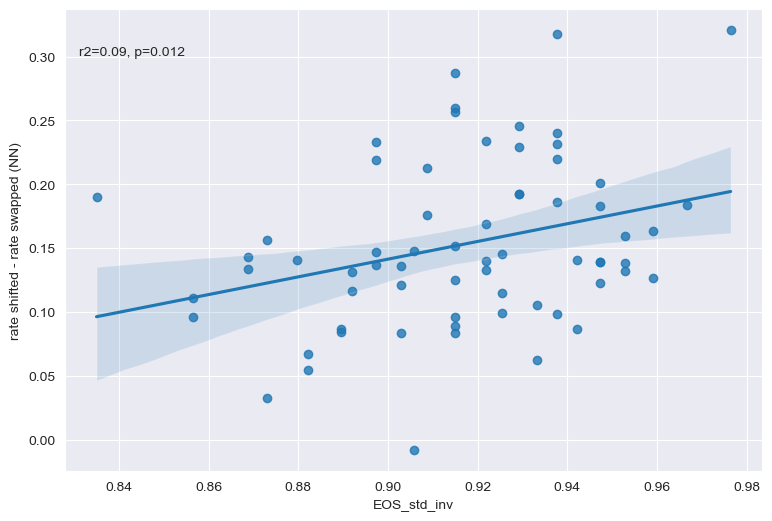

In [15]:
# Correlation with evenness of spread

studyII_GL['EOS_std_inv'] = 1-studyII_GL['EOS_std']
correlation(x="EOS_std_inv", normalize=False, diatonic="include", dataset=studyII_GL, width=9)


plt.savefig(ROOT_DIR + "/Plots/Study II std of error from perfect evenness correlation.svg")

if Run_Stats:
    temp = studyII_GL #loading dataset
    temp = temp.groupby("set").mean(numeric_only=True).reset_index() #collapsing subject by set
    stat_no_perm = stats.pearsonr(temp["EOS_std_inv"], temp["rate shifted - rate swapped (NN)"])
    print(stat_no_perm)
    print(stat_no_perm[0])

### Likert Ratings
#### "Some notes felt more important than others." correlation with scores

9999 of 10000p = 0.1044
obs_stat = 0.19821350359092943
PearsonRResult(statistic=0.19821350359092943, pvalue=0.11062266707651662)


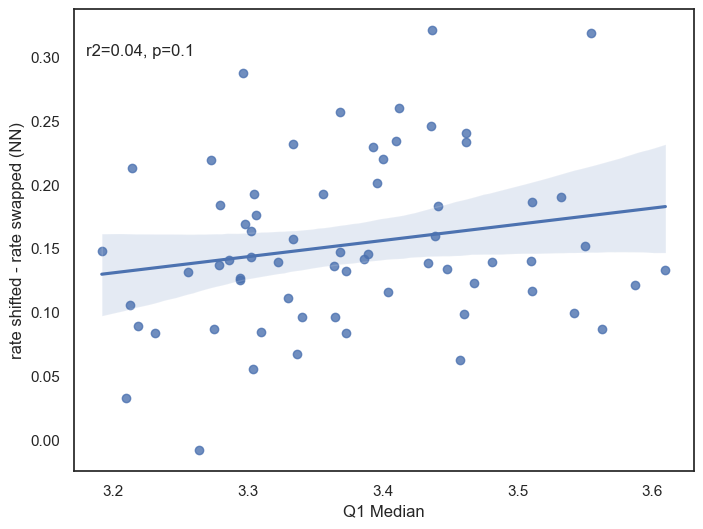

In [21]:
s2 = studyII_GL.groupby('set').mean(numeric_only=True).reset_index()[['set','rate shifted - rate swapped (NN)']]
likert_corr = study_likert.merge(s2, on='set')
correlation(dataset=likert_corr,x='Q1 Median', y='rate shifted - rate swapped (NN)', type='pearson', normalize=False, save_to=StudyII_paths.plots_dir + "Q1 Median correlation.svg")


if Run_Stats:
    temp = likert_corr #loading dataset
    temp = temp.groupby("set").mean(numeric_only=True).reset_index()
    stat_no_perm_importance = stats.pearsonr(temp["Q1 Median"], temp["rate shifted - rate swapped (NN)"])
    print(stat_no_perm_importance)

#### "The audio clip was melodic." correlation with scores

9999 of 10000p = 0.0001
obs_stat = 0.454316091225529
PearsonRResult(statistic=0.454316091225529, pvalue=0.00012721613737161857)


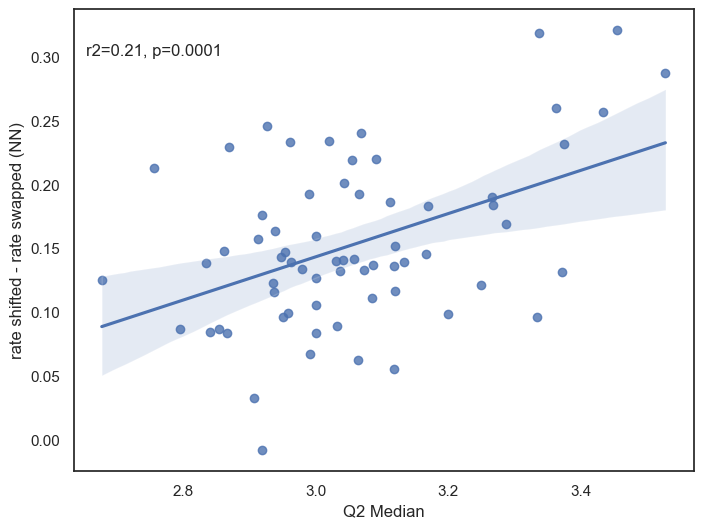

In [20]:
s2 = studyII_GL.groupby('set').mean(numeric_only=True).reset_index()[['set','rate shifted - rate swapped (NN)']]
likert_corr = study_likert.merge(s2, on='set')
correlation(dataset=likert_corr,x='Q2 Median', y='rate shifted - rate swapped (NN)', type='pearson', normalize=False, save_to=StudyII_paths.plots_dir + "Q2 Median correlation.svg")

if Run_Stats:
    temp = likert_corr #loading dataset
    temp = temp.groupby("set").mean(numeric_only=True).reset_index()
    stat_no_perm_melodic = stats.pearsonr(temp["Q2 Median"], temp["rate shifted - rate swapped (NN)"])
    print(stat_no_perm_melodic)

#### "The melody as a whole or parts of it felt familiar." correlation with scores

9999 of 10000p = 0.0639
obs_stat = 0.22953112649915589
SignificanceResult(statistic=0.22953112649915589, pvalue=0.06374954210001325)


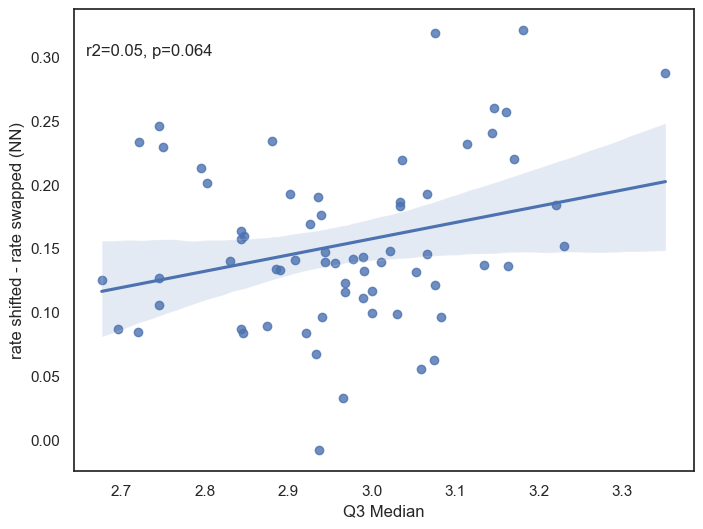

In [22]:
s2 = studyII_GL.groupby('set').mean(numeric_only=True).reset_index()[['set','rate shifted - rate swapped (NN)']]
likert_corr = study_likert.merge(s2, on='set')
correlation(dataset=likert_corr,x='Q3 Median', y='rate shifted - rate swapped (NN)', type='spearman', normalize=False, save_to=StudyII_paths.plots_dir + "Q3 Median correlation.svg")

if Run_Stats:
    temp = likert_corr #loading dataset
    temp = temp.groupby("set").mean(numeric_only=True).reset_index()
    stat_no_perm_framiliar = stats.spearmanr(temp["Q3 Median"], temp["rate shifted - rate swapped (NN)"])
    print(stat_no_perm_framiliar)

### Ridge Regression of Interval contribution

****Ridge regression:***
Score: 0.38519199584745556
 coeffs: 
IC1   -0.014165
IC2   -0.001098
IC3    0.014131
IC4   -0.001343
IC5    0.025456
IC6   -0.017129
dtype: float64

Computing confidence intervals.
['IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6']
DONE.

Running Permutation Tests.
9999 of 10000

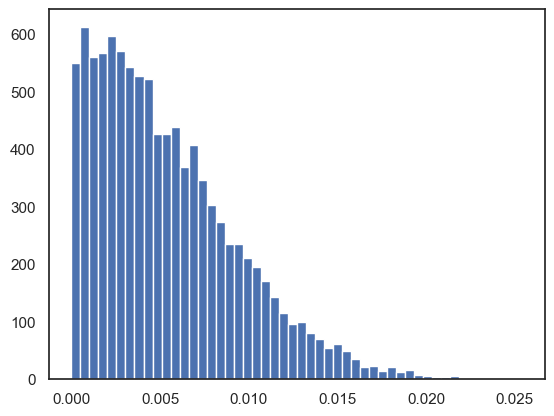

p-values:
[0.0336, 0.8738, 0.0376, 0.8379, 0.0002, 0.0079]
p-values full model:
0.0
DONE.

Plotting:
ci_intervals:
IC1    0.012097
IC2    0.010981
IC3    0.010072
IC4    0.012830
IC5    0.011480
IC6    0.012253
dtype: float64
ci_intervals (applied):
    vars  Coefficient importance  ci_lower  ci_upper
IC1  IC1               -0.014165 -0.026262  0.026262
IC2  IC2               -0.001098 -0.012078  0.012078
IC3  IC3                0.014131  0.004059 -0.004059
IC4  IC4               -0.001343 -0.014173  0.014173
IC5  IC5                0.025456  0.013976 -0.013976
IC6  IC6               -0.017129 -0.029382  0.029382
DONE.


/Users/omriraccah/Documents/Projects_Predoc_ongoing/set_manuscript/set_membership_paper/Shared_Scripts/plotting_functions.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="vars", y="Coefficient importance", data=coefs, palette=["#b2abd2", "#b2abd2", "#b2abd2"])
/Users/omriraccah/Documents/Projects_Predoc_ongoing/set_manuscript/set_membership_paper/Shared_Scripts/plotting_functions.py:129: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x="vars", y="Coefficient importance", data=coefs, palette=["#b2abd2", "#b2abd2", "#b2abd2"])
/Users/omriraccah/Documents/Projects_Predoc_ongoing/set_manuscript/set_membership_paper/Shared_Scripts/plotting_functions.py:142: UserWarning: set_ticklabels() should only be used with a fixed number of tic

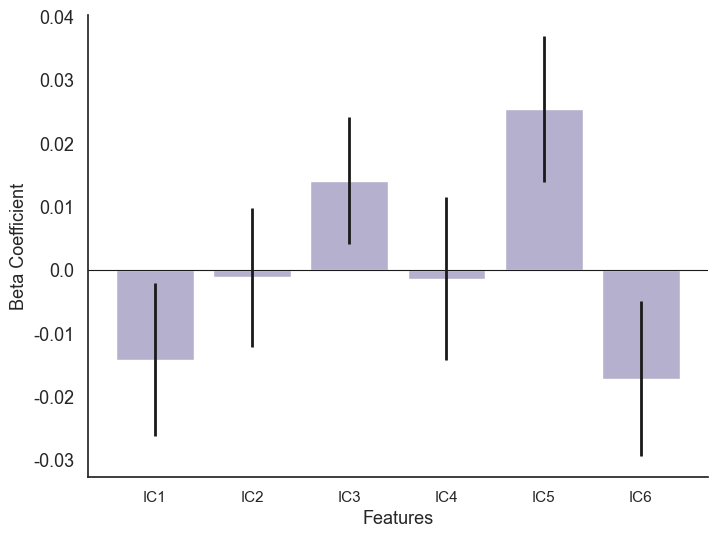

In [13]:
ridge_coeffs(dataset=studyII_GL, X_vars=['IC1','IC2','IC3','IC4','IC5','IC6'], y_vars='rate shifted - rate swapped (NN)')
plt.savefig(StudyII_paths.plots_dir + "interval vector coeffs.svg")

# Study II: Rate of shifted and swapped across all lengths (ignoring neithers)
temp = studyII_GL
temp = temp[temp['set'].isin(['0 2 4 7 9', '0 1 2 4 8'])]
temp['set']
temp = temp[['rate_NN_shifted','rate_NN_swapped','set']]
temp2 = pd.melt(temp,id_vars=["set"],var_name="condition",value_name="rate")
temp2['condition'] = temp2['condition'].replace('rate_NN_shifted',"Shifted")
temp2['condition'] = temp2['condition'].replace('rate_NN_swapped',"Swapped")
sns.catplot(x="set", y="rate", data=temp2, kind="bar", hue="condition", order=['0 1 2 4 8', '0 2 4 7 9'])
plt.ylim([0.2,0.8])
plt.savefig(StudyII_paths.plots_dir + "rate of shifted AND swapped (NN) best and worst.svg")

Uniform Sets Basic Results

set
diminished    0.289344
pentatonic    0.333370
wholetone     0.184056
Name: rate shifted - rate swapped (NN), dtype: float64
set
diminished    0.208333
pentatonic    0.298291
wholetone     0.133333
Name: rate shifted - rate swapped (NN), dtype: float64


/var/folders/bm/tx0fw97s0w5020l7n7hth5mc0000gn/T/ipykernel_4251/658296515.py:25: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=only_data_with_length_12, x="set", y="rate shifted - rate swapped (NN)", color='red', dodge=True, ax=ax.axes[0][0], join=False, errorbar=None, estimator=np.mean)
/var/folders/bm/tx0fw97s0w5020l7n7hth5mc0000gn/T/ipykernel_4251/658296515.py:31: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=only_data_with_length_16, x="set", y="rate shifted - rate swapped (NN)", color='red', dodge=True, ax=ax.axes[0][1], join=False, errorbar=None, estimator=np.mean)


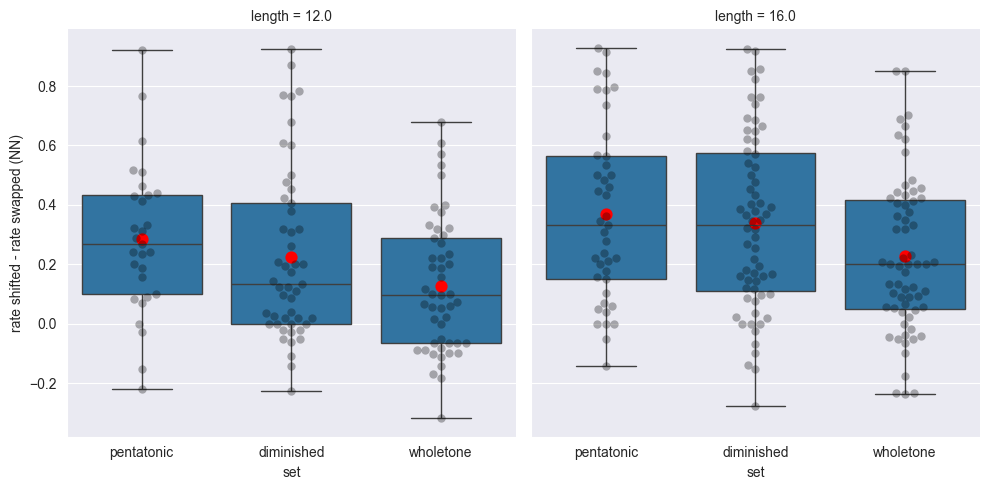

In [9]:
st1 = studyI_GL[studyI_GL['length']!=8]
st1 = st1[st1['set']=='diatonic'].reset_index(drop=True)
st1['study'] = "Exp. 1"

st3 = study_uniform
st3['study'] = "Exp. 3"

new_df = pd.concat([st1,st3]).reset_index(drop=True)

new_df['set'] = new_df['set'].replace('diatonic','pentatonic')
new_df['set'] = new_df['set'].replace('0 2 4 7 9','pentatonic')

# Print the mean of each set
print(new_df.groupby('set')['rate shifted - rate swapped (NN)'].mean())
print(new_df.groupby('set')['rate shifted - rate swapped (NN)'].median())


ax=sns.catplot(x="set", y="rate shifted - rate swapped (NN)", data=new_df, kind='box', col="length")

# Add swarmplot for each length (with opacity 0.3)
only_data_with_length_12 = new_df[new_df['length']==12]
sns.swarmplot(data=only_data_with_length_12, x="set", y="rate shifted - rate swapped (NN)", color='black', dodge=True, ax=ax.axes[0][0], size=6, alpha=0.3)

# Add mean of box plot on top of the swarmplot
sns.pointplot(data=only_data_with_length_12, x="set", y="rate shifted - rate swapped (NN)", color='red', dodge=True, ax=ax.axes[0][0], join=False, errorbar=None, estimator=np.mean)

only_data_with_length_16 = new_df[new_df['length']==16]
sns.swarmplot(data=only_data_with_length_16, x="set", y="rate shifted - rate swapped (NN)", color='black', dodge=True, ax=ax.axes[0][1], size=6, alpha=0.3)

# Add mean of box plot on top of the swarmplot
sns.pointplot(data=only_data_with_length_16, x="set", y="rate shifted - rate swapped (NN)", color='red', dodge=True, ax=ax.axes[0][1], join=False, errorbar=None, estimator=np.mean)

plt.savefig(ROOT_DIR + "/Plots/exp3 and exp1 results.svg")



## Tritave Uniform Sets Basic Results

set
BP_5ue    0.145544
BP_p      0.230616
Name: rate shifted - rate swapped (NN), dtype: float64
set
BP_5ue    0.150000
BP_p      0.191489
Name: rate shifted - rate swapped (NN), dtype: float64


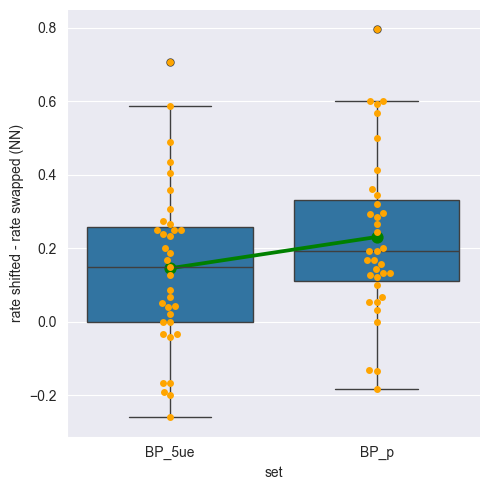

In [10]:
st1 = studyI_GL
st1 = st1[st1['length']==12].reset_index()
st1 = st1[st1['set']=='diatonic'].reset_index(drop=True)
st1['study'] = "Exp. 1"

st3 = study_uniform
st3['study'] = "Exp. 3"

st4 = study_tritave_uniform
st4['study'] = "Exp. 4"

st5 = study_tritave_pentachord
st5['study'] = "Exp. 5"
st5['set'] = st5['set'].replace('0 2 4 7 9','BP_p')
st5['set'] = st5['set'].replace('BP_pentatonic','BP_p')


#ew_df = pd.concat([st1,st3, st4, st5]).reset_index(drop=True)
# new_df = pd.concat([st4, st5]).reset_index(drop=True)
new_df = pd.concat([st5]).reset_index(drop=True)

new_df['set'] = new_df['set'].replace('diatonic','S1_p')
new_df['set'] = new_df['set'].replace('0 3 6 9','BP_u')
new_df['set'] = new_df['set'].replace('0 1 2 4 8','BP_5ue')
new_df['set'] = new_df['set'].replace('0 2 3 7','BP_4ue')
new_df['set'] = new_df['set'].replace('diminished','S3_u4')
new_df['set'] = new_df['set'].replace('wholetone','S3_u6')

# Print the mean of each set
print(new_df.groupby('set')['rate shifted - rate swapped (NN)'].mean())
print(new_df.groupby('set')['rate shifted - rate swapped (NN)'].median())

# Find the mean rate of shifted - rate of swapped for each set and save it to a new column "mean_rate"
new_df['mean_rate'] = new_df.groupby('set')['rate shifted - rate swapped (NN)'].transform('mean')

ax=sns.catplot(x="set", y="rate shifted - rate swapped (NN)", data=new_df, kind='box')
sns.swarmplot(data=new_df, x="set", y="rate shifted - rate swapped (NN)", color='orange', dodge=True, size=5)
# Plot the mean of each set
sns.pointplot(data=new_df, x="set", y="mean_rate", color='green')

plt.savefig(ROOT_DIR + "/Plots/expBPresults.svg")

/var/folders/bm/tx0fw97s0w5020l7n7hth5mc0000gn/T/ipykernel_4251/2122936005.py:16: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:orange'` for the same effect.

  sns.swarmplot(data=st5, x="set", y="rate shifted - rate swapped (NN)", color='orange', hue="is_musician", dodge=True, size=5)


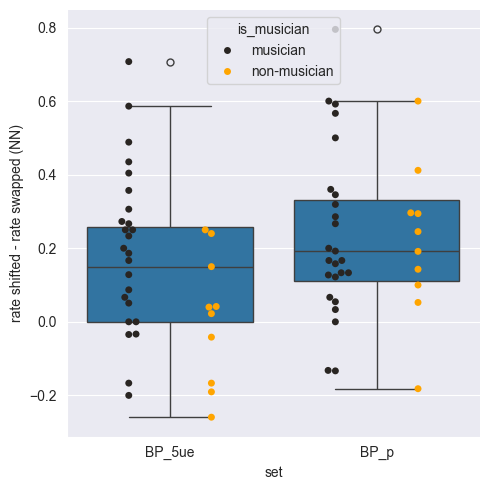

In [11]:
st5 = study_tritave_pentachord
st5['study'] = "Exp. 5"
st5['set'] = st5['set'].replace('0 2 4 7 9','BP_p')
st5['set'] = st5['set'].replace('0 1 2 4 8','BP_5ue')

st5_nm = st5[st5["How many years of formal musical training do you have?"] == "0"]
st5_nm = st5_nm[st5_nm["Do you play any instruments (with or without formal training)?"] == "No"]

non_musician_subjects = st5_nm['subject'].unique()

# Make a new column "is_musician" to indicate whether the subject is a musician or not based on whether they are in the non_musician_subjects list
st5['is_musician'] = st5['subject'].apply(lambda x: "musician" if x not in non_musician_subjects else "non-musician")


ax=sns.catplot(x="set", y="rate shifted - rate swapped (NN)", data=st5, kind='box')
sns.swarmplot(data=st5, x="set", y="rate shifted - rate swapped (NN)", color='orange', hue="is_musician", dodge=True, size=5)

plt.savefig(ROOT_DIR + "/Plots/expBPresults.svg")


In [16]:
# statistics for BP uniform and BP pentachord
BP_u = new_df[new_df['set']=='BP_u']
BP_p = new_df[new_df['set']=='BP_p']
BP_5ue = new_df[new_df['set']=='BP_5ue']
BP_4ue = new_df[new_df['set']=='BP_4ue']
[BP4_t, BP4_p] = stats.ttest_rel(BP_4ue['rate_NN_shifted'].values, BP_u['rate_NN_shifted'].values)
[BP5_t, BP5_p] = stats.ttest_rel(BP_5ue['rate_NN_shifted'].values, BP_p['rate_NN_shifted'].values)

# BP Uniform for each section

## Statistics Expt 3: Across study comparisons
### One-way T-Test for individual sets

In [23]:
Run_Stats = True
if Run_Stats:
    diminished = new_df[new_df['set']=='diminished']
    wholetone = new_df[new_df['set']=='wholetone']
    pentatonic = new_df[new_df['set']=='pentatonic']
    
    # run the same stats with shifted - swapped
    [T_Val_diminished, P_diminished] = stats.ttest_1samp(diminished['rate shifted - rate swapped (NN)'].values, 0)
    [T_Val_WT, P_WT] = stats.ttest_1samp(wholetone['rate shifted - rate swapped (NN)'].values, 0)
    # print with titles
    print("diminished:", T_Val_diminished, P_diminished)
    print("wholetone:", T_Val_WT, P_WT)
    # compute effect sizes
    effect_size_diminished = cohen_d_one_sample(diminished['rate shifted - rate swapped (NN)'].values, 0)
    effect_size_wholetone = cohen_d_one_sample(wholetone['rate shifted - rate swapped (NN)'].values, 0)
    print(effect_size_diminished, effect_size_wholetone)

diminished: 5.3137095700521 3.0462765964705604e-06
wholetone: 3.7502914410291304 0.0004929317256299378
0.7750842012579306 0.5470362291603409


### Comparison with Pentatonic

In [24]:
if Run_Stats:
    # diminished vs. pentatonic
    [diminished_v_penta_T, diminished_v_penta_P] = stats.ttest_ind(pentatonic['rate_NN_shifted'].values, diminished['rate_NN_shifted'].values)
    effect_size_diminished_v_penta = cohen_d_independent_t_test(pentatonic['rate_NN_shifted'].values, diminished['rate_NN_shifted'].values)
    
    # wholetone vs. pentatonic 
    [wholetone_v_penta_T, wholetone_v_penta_P] = stats.ttest_ind(pentatonic['rate_NN_shifted'].values, wholetone['rate_NN_shifted'].values)
    effect_size_wholetone_v_penta = cohen_d_independent_t_test(pentatonic['rate_NN_shifted'].values, wholetone['rate_NN_shifted'].values)
    
    print(diminished_v_penta_P, wholetone_v_penta_P)
    print(diminished_v_penta_T, wholetone_v_penta_T)

0.4055888994250135 0.007856877116179313
0.8364605124324397 2.7324779710951295
